In [1]:
stock = input('Enter a stock ticker: ').upper()

Enter a stock ticker: 


In [76]:
def get_sector(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://finance.yahoo.com/quote/' + ticker + '/profile?p=' + ticker

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    profile = results_page.find('div', class_='asset-profile-container')
    sector = profile.find_all('strong')[0].get_text()
    industry = profile.find_all('strong')[1].get_text()

    return sector, industry
get_sector(stock)

('Industrials', 'Aerospace & Defense')

In [79]:
def sector_data(sector_page_link):
    import requests
    from bs4 import BeautifulSoup
    import re

    response = requests.get(sector_page_link)
    results_page = BeautifulSoup(response.content, 'lxml')
    
    market_cap = results_page.find('div', class_='tab-content-wrapper').find_all('span')[3].get_text()
    market_weight = results_page.find('div', class_='tab-content-wrapper').find_all('span')[5].get_text()

    no_space = r'\S+'
    data = list()
    for i in range(10):
        data.append(re.findall(no_space, results_page.find('div', class_='sec-fundamentals').find_all('td')[i].get_text()))

    pe_last_year = data[0][0]
    pe_this_year = data[1][0]
    ev = data[2][0]
    eps = data[3][0]
    eps_growth = data[4][0]
    revenue_growth = data[5][0]
    roe = data[6][0]
    roi = data[7][0]
    debt_to_equity = data[8][0]
    dividend = data[9][0]

    return market_cap, market_weight, ev, revenue_growth, eps_growth, eps, dividend, pe_last_year, pe_this_year, roe, roi, debt_to_equity

def sector_performance():
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    stats_list = list()
    sector_list = list()
    measure_list = list()

    url = "https://eresearch.fidelity.com/eresearch/goto/markets_sectors/landing.jhtml"

    results_page = requests.get(url)
    soup = BeautifulSoup(results_page.content, 'lxml')
    all_performance = soup.find_all('a', class_='heading1')

    for sectors in all_performance:
        name = sectors.find('strong').get_text()
        link = "https://eresearch.fidelity.com" + sectors.get('href')
        stats_list.append(sector_data(link))
        sector_list.append(name)

    measure_list = ['Market Capital', 'Market Weight', 'Enterprise Value', 'Revenue Growth (TTM)', 'EPS Growth (TTM)', 'EPS (TTM)', 'Dividend Yeild', 'Trailing P/E', 'This Year\'s Estimated P/E', 'ROE (TTM)', 'ROI (TTM)', 'Debt/Equity (TTM)']
    sector_table = pd.DataFrame(stats_list, index=sector_list, columns=measure_list)
    
    return sector_table
sector_performance()

,Market Capital,Market Weight,Enterprise Value,Revenue Growth (TTM),EPS Growth (TTM),EPS (TTM),Dividend Yeild,Trailing P/E,This Year's Estimated P/E,ROE (TTM),ROI (TTM),Debt/Equity (TTM)
Communication Services,$4.47T,9.80%,$251.01B,20.80%,104.01%,$8.60,3.74%,15.76,18.52,18.31%,10.52%,88.66
Consumer Discretionary,$4.73T,9.73%,$245.79B,25.38%,87.57%,$8.26,2.49%,20.44,21.67,52.85%,13.51%,64.99
Consumer Staples,$3.41T,7.50%,$141.39B,3.77%,14.82%,$3.83,3.05%,16.75,20.53,17.62%,12.57%,116.98
Energy,$3.47T,5.51%,$129.13B,28.52%,"1,913.44%",$3.97,4.58%,15.97,13.66,12.78%,8.93%,40.60
Financials,$7.10T,13.82%,$150.35B,11.47%,64.87%,$6.65,3.46%,12.37,10.83,18.74%,6.91%,183.40
Health Care,$5.66T,15.61%,$132.55B,36.98%,21.63%,$3.17,2.28%,45.71,28.74,40.40%,10.77%,258.69
Industrials,$3.94T,9.51%,$58.83B,11.88%,54.99%,$7.18,2.31%,19.64,25.48,-107.20%,15.15%,178.59
Information Technology,$6.87T,19.70%,$288.26B,15.38%,71.24%,$4.21,1.85%,27.30,21.06,21.03%,14.68%,67.50
Materials,$1.76T,2.67%,$48.13B,27.59%,40.35%,$3.43,3.19%,15.56,17.02,16.44%,4.91%,73.84
Real Estate,$1.21T,2.95%,$35.88B,9.35%,34.12%,$2.43,4.01%,29.24,25.65,10.05%,4.06%,56.26


### Find competitors

In [69]:
def get_competitors(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = 'https://www.nasdaq.com/symbol/' + ticker + '/stock-comparison'

    response = requests.get(url)
    results_page = BeautifulSoup(response.content, 'lxml')
    table = results_page.find('div', class_='genTable thin')
    competitors = list()
    for i in range(4):
        competitors.append(table.find_all('input')[i].get('value'))
    
    return competitors
get_competitors(stock)

['UTX', 'TXT', 'HEI', 'ERJ']

In [4]:
def get_financial_stats(ticker):
    import requests
    from bs4 import BeautifulSoup
    url = "https://finance.yahoo.com/quote/" + ticker + "/key-statistics?p=" + ticker
    
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    stats_lists = results_page.find_all('table')
    test_list = list()
    for i in stats_lists:
        stat_name = i.find_all('span')
        stock_stat = i.find_all('td',class_='Fz(s) Fw(500) Ta(end)')
        for j in range(len(stock_stat)):
            if not stat_name[j].get_text() == 'N/A':
                test_list.append((stat_name[j].get_text(),stock_stat[j].get_text()))
    return test_list
get_financial_stats('BA')

[('Market Cap (intraday)', '196.92B'),
 ('Enterprise Value', '179.33B'),
 ('Trailing P/E', '20.36'),
 ('Forward P/E', '19.12'),
 ('PEG Ratio (5 yr expected)', '0.96'),
 ('Price/Sales', '2.03'),
 ('Price/Book', 'N/A'),
 ('Enterprise Value/Revenue', '14.23'),
 ('Fiscal Year Ends', 'Dec 31, 2017'),
 ('Most Recent Quarter', 'Sep 30, 2018'),
 ('Profit Margin', '10.41%'),
 ('Operating Margin', '10.80%'),
 ('Return on Assets', '6.36%'),
 ('Return on Equity', 'N/A'),
 ('Revenue', '96.94B'),
 ('Revenue Per Share', '165.43'),
 ('Quarterly Revenue Growth', '3.80%'),
 ('Gross Profit', '17.33B'),
 ('EBITDA', '12.6B'),
 ('Net Income Avi to Common', '10.09B'),
 ('Diluted EPS', '17.03'),
 ('Quarterly Earnings Growth', '30.60%'),
 ('Total Cash', '9.99B'),
 ('Total Cash Per Share', '17.59'),
 ('Total Debt', '11.88B'),
 ('Total Debt/Equity', 'N/A'),
 ('Current Ratio', '-2.27'),
 ('Operating Cash Flow', '15.28B'),
 ('Levered Free Cash Flow', '7.93B'),
 ('Beta (3Y Monthly)', '1.59'),
 ('52-Week Change', '2

In [71]:
def get_row(ticker,measure_list):
    from pandas_datareader import data as web
    a = get_financial_stats(ticker)
    row = list()
    row.append(web.DataReader(ticker,"yahoo").iloc[-1,3])
    for i in measure_list:
        if not i == "Price":
            appended = 0
            for j in a:
                if j[0] == i:
                    row.append(j[1])
                    appended = 1
            if appended == 0:
                row.append('N/A')   
    return row

In [72]:
def competitor(ticker):
    import numpy as np

    r = get_competitors(ticker)
    r.insert(0, ticker)

    m = list((1,2,3,4,5))
    for i in range(5):
        if get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'B':
            m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1])
        elif get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'M':
            m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1]) / 1000
        elif get_row(r[i],['Market Cap (intraday)'])[1][-1] == 'T':
            m[i] = float(get_row(r[i],['Market Cap (intraday)'])[1][:-1]) * 1000

    diff = list()
    for i in range(1,5):
        diff.append(abs(m[0]-m[i]))

    competitor = r[np.argmin(diff)+1]
    return competitor
competitor(stock)

'UTX'

### Comparison Table

In [88]:
def comp_stat_table(ticker):
    import pandas as pd
    measure_list = ['Price','Market Cap (intraday)','Enterprise Value','Quarterly Revenue Growth','Quarterly Earnings Growth','Diluted EPS','Trailing Annual Dividend Yield','5 Year Average Dividend Yield','Payout Ratio','Trailing P/E','Forward P/E','PEG Ratio (5 yr expected)','Return on Equity','Total Debt/Equity','Book Value Per Share','Beta (3Y Monthly)']
    r = get_competitors(ticker)
    r.insert(0, ticker)

    s_row = get_row(ticker,measure_list)
    a_row = get_row(r[1],measure_list)
    b_row = get_row(r[2],measure_list)
    c_row = get_row(r[3],measure_list)
    d_row = get_row(r[4],measure_list)
    
    comprehensive_list = ['Price', 'Market Cap', 'Enterprise Value', 'Revenue Growth (Quarter)', 'Earnings Growth (Quarter)', 'EPS', 'Dividend Yield', '5-Year Avg Dividend Yield', 'Payout Ratio', 'Trailing P/E', 'Forward P/E', 'PEG', 'ROE (TTM)', 'Debt/Equity', 'Book Value/Share', 'Beta']

    stats_list = [s_row,a_row,b_row,c_row,d_row]
    final_table = pd.DataFrame(stats_list, index=r, columns=comprehensive_list)

    return final_table
comp_stat_table(stock)

,Price,Market Cap,Enterprise Value,Revenue Growth (Quarter),Earnings Growth (Quarter),EPS,Dividend Yield,5-Year Avg Dividend Yield,Payout Ratio,Trailing P/E,Forward P/E,PEG,ROE (TTM),Debt/Equity,Book Value/Share,Beta
BA,346.760010,196.92B,179.33B,3.80%,30.60%,17.03,1.91%,2.27,38.55%,20.36,19.12,0.96,N/A,N/A,N/A,1.59
UTX,121.839996,97.59B,131.38B,9.60%,-6.90%,6.22,2.31%,2.27,45.02%,19.58,15.64,1.98,16.07%,116.20,40.57,1.12
TXT,56.139999,13.64B,16.47B,-8.20%,254.10%,3.36,0.14%,0.18,2.35%,16.73,15.68,0.99,15.32%,69.75,22.82,1.79
HEI,84.519997,9.82B,12.04B,19.00%,46.80%,1.79,0.14%,0.21,5.44%,47.24,40.83,2.45,18.75%,39.89,10.04,0.86
ERJ,22.450001,4.24B,5.58B,10.50%,N/A,-0.73,0.03%,N/A,"Oct 18, 2018",N/A,-9.32,0.90,-3.29%,110.23,22.27,-1.32


In [49]:
def get_prices(ticker):
    import datetime
    import dateutil.relativedelta
    import numpy as np
    import pandas_datareader.data as web

    stocks = ticker, get_competitors(ticker)
    five_years_ago = (datetime.date.today() - dateutil.relativedelta.relativedelta(years=5)).strftime('%Y-%m-%d')
    today = datetime.date.today().strftime('%Y-%m-%d')

    prices = web.DataReader(np.hstack(('SPY',)+stocks),'yahoo',five_years_ago,today)['Adj Close']
    return prices

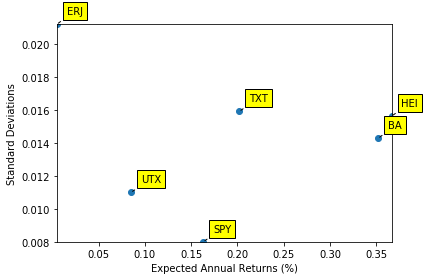

In [56]:
def expected_returns(ticker):
    import matplotlib.pyplot as plt
    %matplotlib inline
    import pylab as plot

    returns = get_prices(stock).pct_change()

    plt.xlabel('Expected Annual Returns (%)')
    plt.ylabel('Standard Deviations')
    for label,x,y in zip(returns.columns,returns.mean()*365,returns.std()):
        plt.annotate(
            label, 
            xy = (x,y),
            xytext = (10,10),
            textcoords = 'offset points',
            bbox = dict(fc = 'yellow'),
            arrowprops = dict(arrowstyle = '-')
        )
    plot.ylim([min(returns.std()),max(returns.std())])
    plot.xlim([min(returns.mean()*365),max(returns.mean()*365)])
    plt.scatter(returns.mean()*365, returns.std())
expected_returns(stock)

In [267]:
def correlation(ticker):
    returns = get_prices(ticker).pct_change()
    return returns.corr() # correlation between each stock and S&P 500
correlation(stock)

Symbols,IT,JCI,RYB,SCI,SPY,TAL
Symbols,,,,,,
IT,1.000000,0.327362,0.115291,0.379835,0.563006,0.186507
JCI,0.327362,1.000000,0.086984,0.349114,0.556438,0.138241
RYB,0.115291,0.086984,1.000000,0.109483,0.127165,0.158404
SCI,0.379835,0.349114,0.109483,1.000000,0.587681,0.152415
SPY,0.563006,0.556438,0.127165,0.587681,1.000000,0.290704
TAL,0.186507,0.138241,0.158404,0.152415,0.290704,1.000000


In [5]:
def plot_prices(ticker):
    import statsmodels.api as sm
    import matplotlib.patches as mpatches
    import pylab as plot

    p = get_prices(ticker)
    x = p['SPY']
    x = sm.add_constant(x)
    y = p[ticker]
    model = sm.OLS(y,x,missing='drop')
    regression = model.fit()
    print(regression.summary())
    
    fig,ax = plt.subplots(figsize=(20,10))
    blue_patch = mpatches.Patch(color='blue', label=ticker)
    orange_patch = mpatches.Patch(color='orange', label='S&P 500 (Fitted Value)')
    plt.legend(handles=[blue_patch,orange_patch])
    params = {'legend.fontsize': 15, 'legend.handlelength': 2}
    plot.rcParams.update(params)

    ax.plot(y)
    ax.plot(regression.fittedvalues)

In [6]:
plot_prices(stock)

NameError: name 'get_prices' is not defined

                            OLS Regression Results                            
Dep. Variable:                     JD   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     570.9
Date:                Sat, 01 Dec 2018   Prob (F-statistic):          1.28e-102
Time:                        17:42:57   Log-Likelihood:                -3615.8
No. Observations:                1142   AIC:                             7236.
Df Residuals:                    1140   BIC:                             7246.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3092      1.098      4.837      0.0

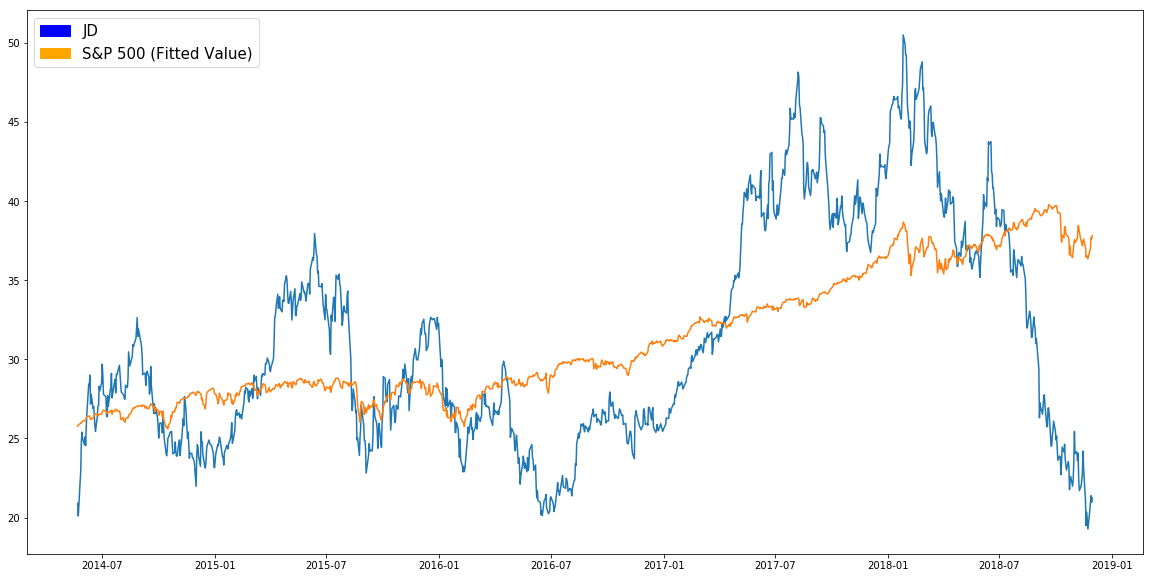

In [225]:
plot_prices('JD')

0.34137 851.22
0.34137 184.73
0.34137 122.47
0.34137 108.03
[850.87863, 184.38862999999998, 122.12863, 107.68863]
                            OLS Regression Results                            
Dep. Variable:                    CRM   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Sat, 01 Dec 2018   Prob (F-statistic):               0.00
Time:                        17:42:16   Log-Likelihood:                -4540.3
No. Observations:                1260   AIC:                             9085.
Df Residuals:                    1258   BIC:                             9095.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

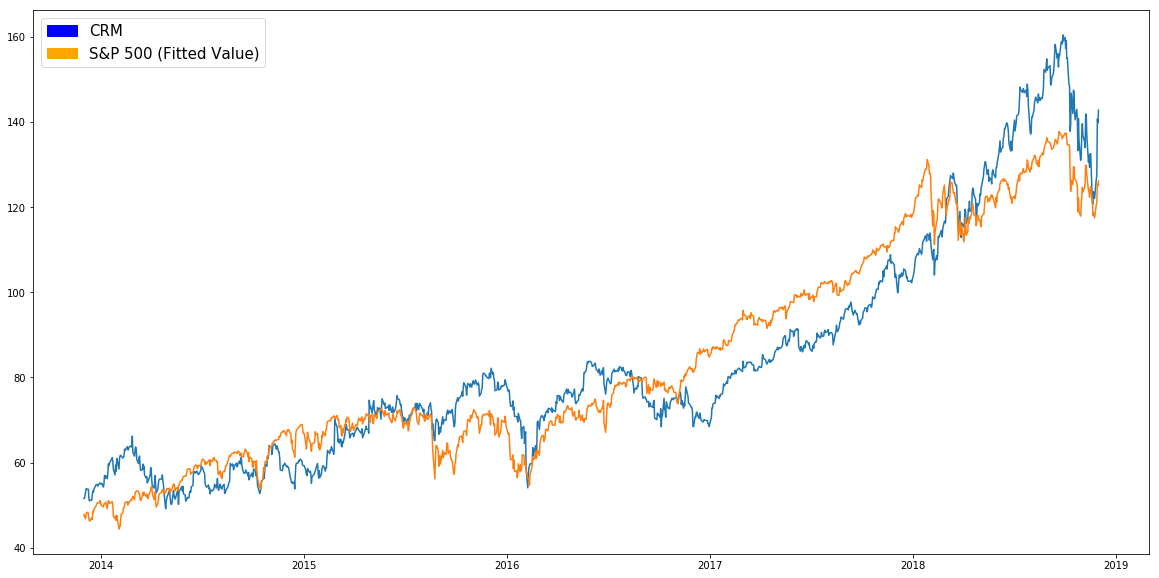

In [224]:
plot_prices(competitor(stock))

                            OLS Regression Results                            
Dep. Variable:                   BABA   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     5505.
Date:                Sat, 01 Dec 2018   Prob (F-statistic):               0.00
Time:                        17:46:20   Log-Likelihood:                -4535.6
No. Observations:                1059   AIC:                             9075.
Df Residuals:                    1057   BIC:                             9085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -144.0345      3.588    -40.148      0.0

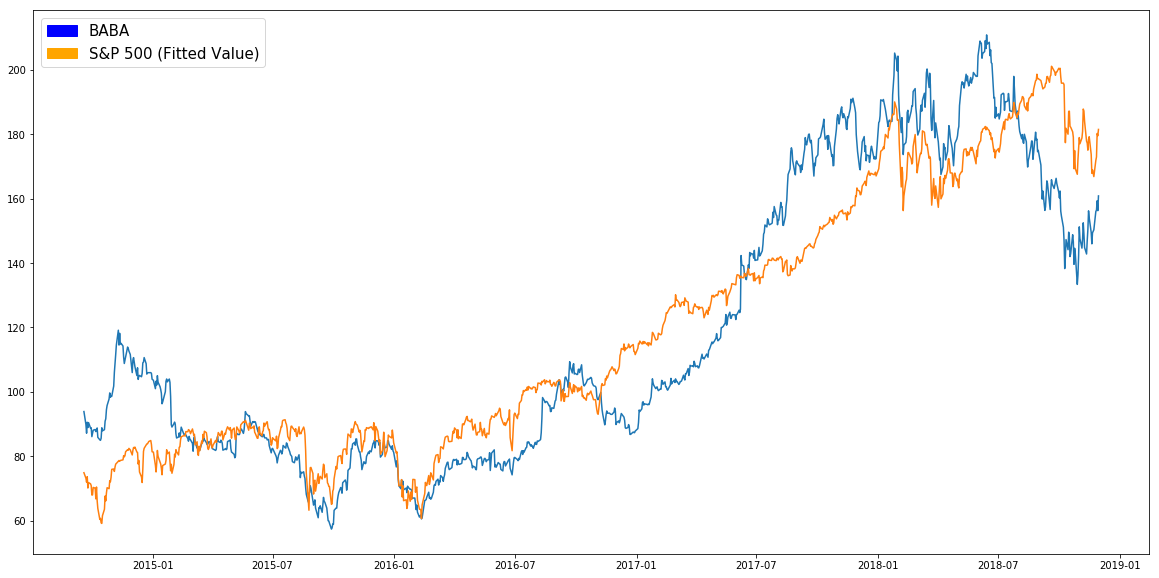

In [229]:
plot_prices('BABA')